# Denoising with the deep decoder and the DIP

Here, we demonstrate the denoising performance on an example image; specifically we demonstrate how the mean squared error (MSE) develops over time.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from models import *
#from utils.denoising_utils import *

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def denoise(img_noisy_np,img_clean_np,net,num_channels,numit = 1900,rn = 0.0,find_best=True,upsample_mode='bilinear',plot_after=[1]):
    mse_n, mse_t, ni, net, out_imgs = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=np_to_var(img_noisy_np).type(dtype),
                        net=net,
                        img_clean_var=np_to_var(img_clean_np).type(dtype),
                        find_best=find_best,
                        upsample_mode=upsample_mode,
                        #OPTIMIZER='SGD',LR=0.1,
                        plot_after = plot_after,
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t, out_imgs

## Load imagenet images

In [3]:
path = './test_data/'
img_name = "astronaut"
#img_name = "mri"
img_name = "phantom256"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
#img_pil = load_and_crop(img_path,target_width=256,target_height=256)

img_clean_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_clean_np).type(dtype)

## Generate noisy image

In [4]:
def get_noisy_img(img_np,sig=25.0,noise_same = True):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)
    
    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    #img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np #,img_noisy_var

def get_noise(sig=30,noise_same = False,sh=None): # sh is shape
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        if sh is None:
            sh = img_clean_np.shape[1:]
        noise = np.random.rand(sh[0],sh[1]) #np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_clean_np.shape[0] )
    else: # add independent noise in each channel
        if sh is None:
            sh = img_clean_np.shape
        noise = np.random.rand(sh[0],sh[1],sh[2]) # np.random.normal(scale=sigma, size=img_np.shape)

    img_noisy_np = np.clip( noise , 0, 1).astype(np.float32)
    #img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np

In [5]:
np.max(img_clean_np)

0.019607844

#  Get image, noise, and noisy image

In [6]:
sig = 40.0
noise_same = True

img_clean_np *= 1.0/np.max(img_clean_np)

img_noise_np = get_noise(noise_same=noise_same)

#img_noisy_np = get_noisy_img(img_clean_np,sig,noise_same)

img_noise_np = get_noise(noise_same=noise_same)
img_noise_np *= np.linalg.norm(img_clean_np)/np.linalg.norm(img_noise_np)

#img_noisy_np = img_clean_np + 0.5*img_noise_np

img_noisy_np = get_noisy_img(img_clean_np,sig,noise_same)

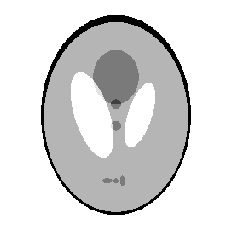

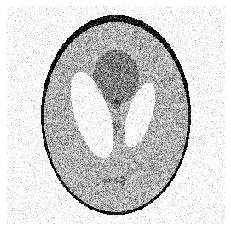

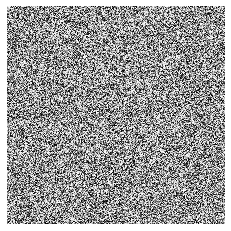

In [7]:
def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')
    plt.axis('off')
        
myimgshow(plt,img_clean_np)
plt.show()
myimgshow(plt,img_noisy_np)
plt.show()
myimgshow(plt,img_noise_np)
plt.show()

In [8]:
numit = 10010
plot_after = [10,100,150,200,250,300,400,600,800,1200,10000]

In [9]:
def savefig(filename,img):
    #plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')
    #plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    plt.imshow(img,cmap='Greys',interpolation='none')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')

## DIP

In [ ]:
img = img_clean_np

output_depth = img.shape[0]
net = get_net(32, 'skip', 'reflection',n_channels=output_depth,skip_n33d=128,
              skip_n33u=128,skip_n11=4,num_scales=5,upsample_mode='bilinear').type(dtype)
num_channels = [32]*5

out_img_np, mse_t_clean,out_imgs = denoise(img,img_clean_np,net,num_channels=num_channels,numit = numit,upsample_mode="none",plot_after=plot_after)

plt.plot(np.log(mse_t_clean))

input shape:  [1, 32, 256, 256]
optimize with adam 0.01


In [11]:
img = img_noise_np

output_depth = img.shape[0]
net = get_net(32, 'skip', 'reflection',n_channels=output_depth,skip_n33d=128,
              skip_n33u=128,skip_n11=4,num_scales=5,upsample_mode='bilinear').type(dtype)
num_channels = [32]*5
    
out_img_np, mse_t_noise, out_imgs = denoise(img,img_clean_np,net,num_channels=num_channels,numit = numit,upsample_mode="none",plot_after=plot_after)


input shape:  [1, 32, 256, 256]
optimize with adam 0.01


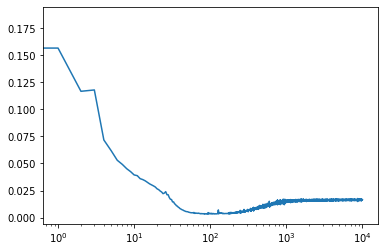

In [12]:
img = img_noisy_np

output_depth = img.shape[0]
net = get_net(32, 'skip', 'reflection',n_channels=output_depth,skip_n33d=128,
              skip_n33u=128,skip_n11=4,num_scales=5,upsample_mode='bilinear').type(dtype)
num_channels = [32]*5

out_img_np, mse_t_noisy, out_imgs = denoise(img,img_clean_np,net,num_channels=num_channels,numit = numit,upsample_mode="none",plot_after=plot_after)

plt.semilogx(mse_t_noisy)

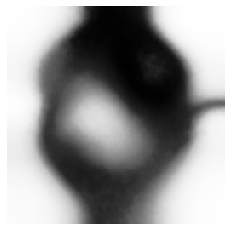

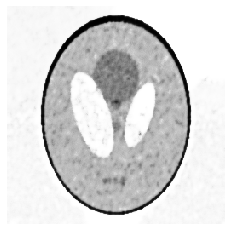

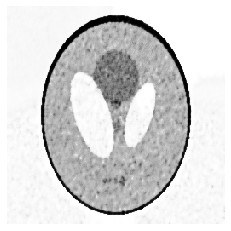

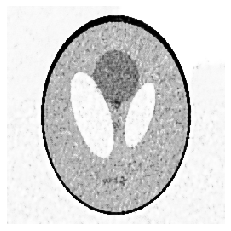

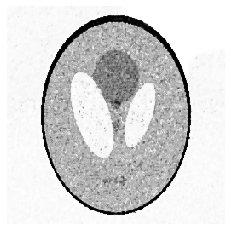

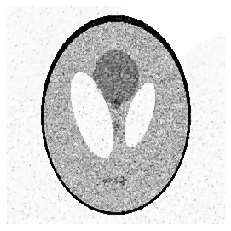

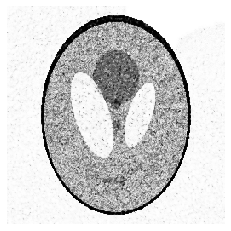

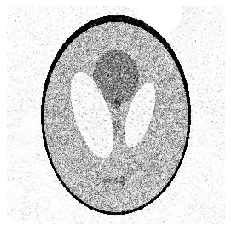

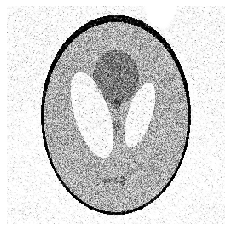

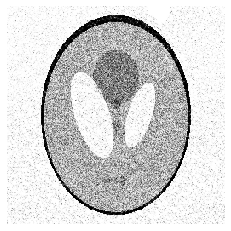

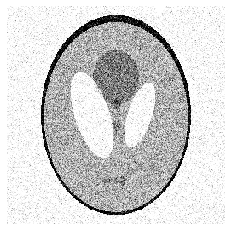

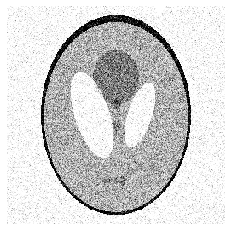

In [13]:
for nu,img in zip(plot_after,out_imgs):
    myimgshow(plt,img)
    plt.show()
    savefig(img_name + "DIP_at_" + str(nu) + ".png",img[0])
    

In [14]:
A = np.array( [ mse_t_clean, mse_t_noise, mse_t_noisy] )
savemtx_for_logplot(A,"DIP_denoising_curves.dat")

## Deep Decoder

### Image

input shape:  [1, 256, 16, 16]
optimize with adam 0.01


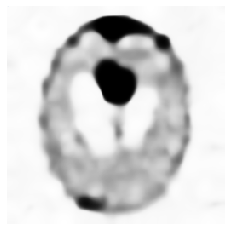

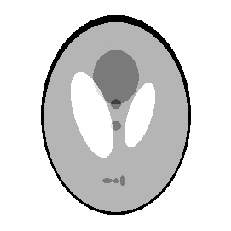

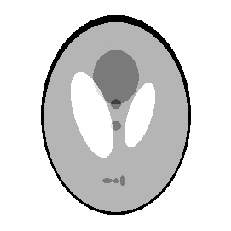

In [15]:
numit = 10010
plot_after = [10,10000]

num_channels = [256]*4

img = img_clean_np

net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=False).type(dtype)
out_img_np, mse_t_clean, out_imgs = denoise(img,img_clean_np,net,num_channels=num_channels,numit = numit,plot_after=plot_after)

plt.plot(np.log(mse_t_clean))

for nu,img in zip(plot_after,out_imgs):
    myimgshow(plt,img)
    plt.show()
    savefig(img_name + "image_DD_at_" + str(nu) + ".png",img[0])
    


### Noise

input shape:  [1, 256, 16, 16]
optimize with adam 0.01


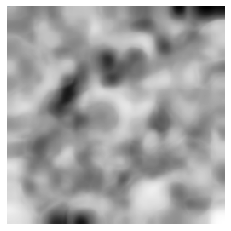

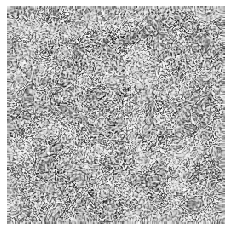

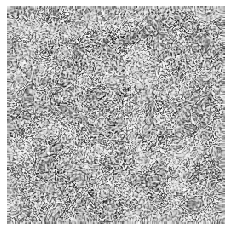

In [16]:
numit = 10010
plot_after = [10,10000]

img = img_noise_np

net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=False).type(dtype)
out_img_np, mse_t_noise, out_imgs = denoise(img,img_clean_np,net,num_channels=num_channels,numit = numit,plot_after=plot_after)

plt.plot(np.log(mse_t_noise))

for nu,img in zip(plot_after,out_imgs):
    myimgshow(plt,img)
    plt.show()
    savefig(img_name + "noise_DD_at_" + str(nu) + ".png",img[0])
    

### Noisy image

input shape:  [1, 256, 16, 16]
optimize with adam 0.01


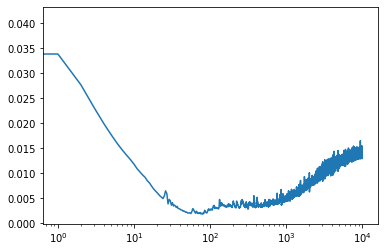

In [17]:
numit = 10010
plot_after = [10,100,150,200,250,300,400,600,800,1200,10000]

img = img_noisy_np

net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=True).type(dtype)

out_img_np, mse_t_noisy, out_imgs = denoise(img,img_clean_np,net,num_channels=num_channels,numit = numit,plot_after=plot_after)

#plt.semilogx(mse_t)
plt.semilogx(mse_t_noisy[10:])


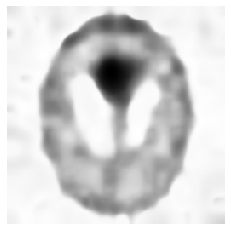

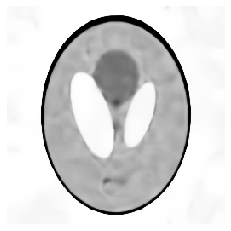

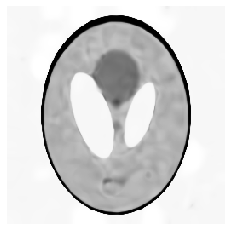

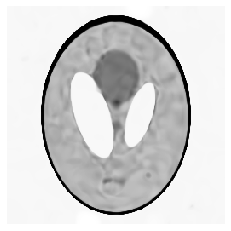

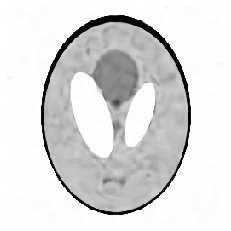

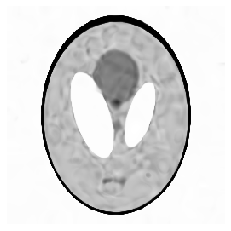

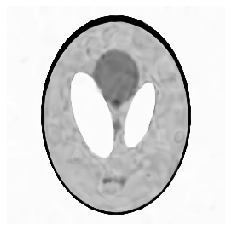

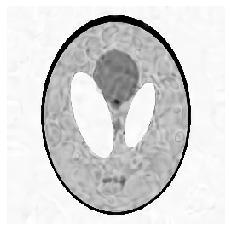

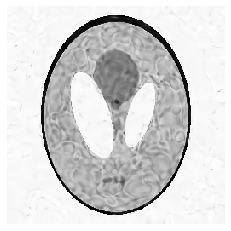

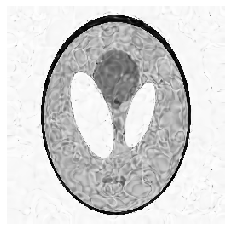

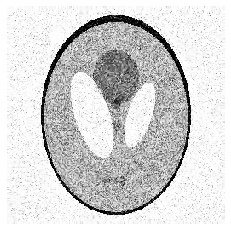

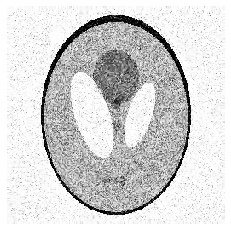

In [18]:
for nu,img in zip(plot_after,out_imgs):
    myimgshow(plt,img)
    plt.show()
    savefig(img_name + "DD_at_" + str(nu) + ".png",img[0])   

In [19]:
A = np.array( [ mse_t_clean, mse_t_noise, mse_t_noisy] )
savemtx_for_logplot(A,"DD_denoising_curves.dat")